In [4]:
import scipy as sp
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = 20

In [5]:
from newfastdigitizer2root_ygk import *

In [12]:
#dir = "/project/projectdirs/ld_tes/data/ACBias/20210916_ACBias/"
dir = "/project/projectdirs/ld_tes/data/ACBias/20210920_ACBias/"
#dir = "/project/projectdirs/ld_tes/data/ACBias/20210922_ACBias/"
run = "HFRun2"
partial = "_1"

In [13]:
header_info, ch_info = read_new_header_file(dir+run+".hdr")

In [14]:
header_info = parse_header_time(header_info,0)
#print(header_info)
#print(ch_info)
header_info

{'Iteration number': '0',
 'Iteration time': '60',
 'Sampling Frequency': '10000000',
 'Acquired points': '250000',
 'Trigger Position': '10',
 'Trigger channel': '0',
 '# channels': '2',
 'CH0 Vertical range': '30.000000',
 'CH0 Input impedance': '1000000',
 'CH0 Probe attenuation': '1',
 'CH1 Vertical range': '0.200000',
 'CH1 Input impedance': '1000000',
 'CH1 Probe attenuation': '1',
 'BK channel': '1',
 'BK waveform': '',
 'BK amplitude': '0.000000',
 'BK offset': '0.000000',
 'BK frequency': '0.000000',
 'BK phase': '0.000000',
 'Start time UNIX': 1632176812.495564,
 'Start date': '9/20/2021',
 'Start time': '3:26:52 PM',
 'Final iteration': '6',
 'Real time': '332.456269',
 'Live time': '1.999848',
 'Trigger number': '2712',
 'Stop time UNIX': 1632177146.1676488,
 'Stop date': '9/20/2021',
 'Stop Time': '3:32:26 PM'}

In [15]:
byteFile = all_bytes_from_file(dir+run+partial+".dat")

In [16]:
parsed_data = parse_binary_data(byteFile, header_info, ch_info, endian='<')

Read 0 records
Read 10 records
Read 20 records
Read 30 records
Read 40 records
Read 50 records
Read 60 records
Read 70 records
Read 80 records
Read 90 records
Read 100 records
Read 110 records
Read 120 records
Read 130 records
Read 140 records
Read 150 records
Read 160 records
Read 170 records
Read 180 records
Read 190 records
Read 200 records
Read 210 records
Read 220 records
Read 230 records
Read 240 records
Read 250 records
Read 260 records
Read 270 records
Read 280 records
Read 290 records
Read 300 records
Read 310 records
Read 320 records
Read 330 records
Read 340 records
Read 350 records
Read 360 records
Read 370 records
Read 380 records
Read 390 records
Read 400 records
Read 410 records
Read 420 records
Read 430 records
Read 440 records
Read 450 records
Read 460 records
Read 470 records
Read 480 records


Sampling frequency = 10.0 MHz
Baseline = -2.72e-03 V


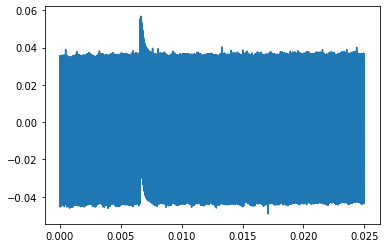

In [18]:
#d0=parsed_data[5][0]['data']
ch=1
frame=0
d1=parsed_data[frame][ch]['data']
fs = float(header_info['Sampling Frequency'])
print('Sampling frequency = {0:.1f} MHz'.format(fs/1e6))

t = np.arange(len(d1))/fs

toff=0.0
tl=0.003e2
off=int(toff*fs)
l=int(tl*fs)

%matplotlib inline
plt.plot(t[off:off+l],d1[off:off+l])
print('Baseline = {0:8.2e} V'.format(np.mean(d1[off:off+l])))
#plt.scatter(d0[:],d1[:],marker='.')

Mean filter: baselineRMS = 0.00043323543515368606
Mean filter: amplitude = 0.01884377001602853
Mean filter: res = 2.30%, 137.9 eV
RMS filter: baselineRMS = 4.0646265206711094e-05
RMS filter: amplitude = 3.587227582633329e-05
RMS filter: res = 113.31%, 6798.5 eV


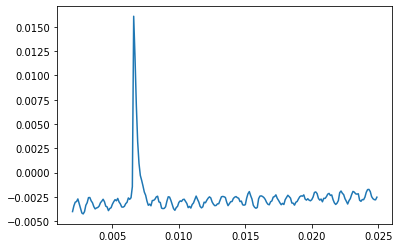

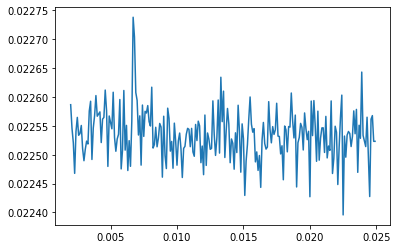

In [19]:
# decimating mean and RMS filter
def decFilter(data,decFact):
    ndec = int(len(data)/decFact)

    wf_mean = np.zeros(ndec)
    wf_rms  = np.zeros(ndec)
    for i in range(ndec):
        wf_mean[i] = np.mean(data[i*decFact:(i+1)*decFact])
        wf_rms[i]  = np.std(data[i*decFact:(i+1)*decFact])

    return (wf_mean,wf_rms)
    
# ass
def peakDetect(data,threshold):
    ipeak = find_peaks(data,height=threshold)
    peak = ipeak[1]['peak_heights']
    return peak
    
def baseline(data):
    baseline = np.mean(data)
    baselineRMS = np.std(data)    
    return (baseline,baselineRMS)

def AmpAndBaseline(data,threshold,preVeto,postVeto):
    peaks = find_peaks(data,height=threshold)
    ipeak = peaks[0]
    height = peaks[1]['peak_heights']
    
    baseIndices = np.arange(len(wf))
    if len(ipeak):
        baseIndices = ~np.in1d(np.arange(len(wf)),np.concatenate([np.arange(i-preVeto,i+postVeto) for i in ipeak]))
    (baseAve,baseRMS) = baseline(wf[baseIndices])
    amp = height-baseAve
    return (amp,baseAve,baseRMS)
    
    
decFact = 1000
ndec = int(len(d1)/decFact)
tdec = np.arange(ndec)/fs*decFact
(wf_mean,wf_rms) = decFilter(d1,decFact)

toff=0.002
tl=0.2
off=int(toff*fs/decFact)
l=int(tl*fs/decFact)

plt.plot(tdec[off:off+l],wf_mean[off:off+l])
plt.figure()
plt.plot(tdec[off:off+l],wf_rms[off:off+l])

# resolution with mean filter
toffbase = 0.01
tlbase=0.02
offbase=int(toffbase*fs/decFact)
lbase=int(tlbase*fs/decFact)
peak = peakDetect(wf_mean[off:off+l],threshold=0.0)[0]
(baseAve,baseRMS) = baseline(wf_mean[offbase:offbase+lbase])

print('Mean filter: baselineRMS = {}'.format(baseRMS))
print('Mean filter: amplitude = {}'.format(peak-baseAve))
print('Mean filter: res = {0:.2f}%, {1:.1f} eV'.format(100*baseRMS/(peak-baseAve),6000*baseRMS/(peak-baseAve)))

peak = peakDetect(wf_rms[off:off+l],threshold=0.002)[0]
(baseAve,baseRMS) = baseline(wf_rms[offbase:offbase+lbase])

print('RMS filter: baselineRMS = {}'.format(baseRMS))
print('RMS filter: amplitude = {}'.format(peak-baseAve))
print('RMS filter: res = {0:.2f}%, {1:.1f} eV'.format(100*baseRMS/(peak-baseAve),6000*baseRMS/(peak-baseAve)))


In [20]:
parsed_data[0]

{0: {'header': [1632176812.7273502, 0.0005391782615333796, 0, 250000],
  'data': array([ 0.37095464,  1.26814727,  1.34578894, ..., -1.08698338,
          0.27605927,  1.23363986])},
 1: {'header': [1632176812.7273502, 3.3969670312217204e-06, 1, 250000],
  'data': array([-0.0057069 , -0.00097833,  0.00195665, ..., -0.00880494,
         -0.00418506,  0.00108703])}}

Text(0, 0.5, 'Frequency spectrum (V/sqrt(Hz)')

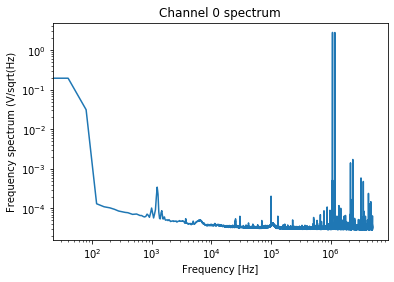

In [21]:
from scipy.signal import blackman

ch = 0
N = len(d1)
N2 = N//2
freq = fftfreq(N,1./fs)
df = freq[1]-freq[0]
w = blackman(N)

anps = np.zeros(N)
for event in parsed_data.values():
    z = fft(event[ch]['data']*w)
#    z = fft(event[ch]['data'])
    anps += np.abs(z)

anps *= 2./N/len(parsed_data)/0.42          # 0.42 for Blackman window
#anps *= 2./N/len(parsed_data)
plt.loglog(freq[0:N2], anps[0:N2])
plt.title('Channel {0:d} spectrum'.format(ch))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency spectrum (V/sqrt(Hz)")

In [22]:
# find LO frequency
ipeak = find_peaks(anps[:N2],threshold=0.5)
print('Found {0:d} peaks: {1:} Hz'.format(len(ipeak[0]),freq[ipeak[0]]))
#print(freq[ipeak[0]],freq[ipeak[0][3]]-freq[ipeak[0][2]])
if0=ipeak[0][0]

# improve the precision by computing the mean frequency in small range
f0 = np.average(freq[if0-3:if0+4],weights=anps[if0-3:if0+4])
f0=freq[if0]
print('Carrier frequency = {0:.2f} Hz'.format(f0))
#print(f0)

Found 2 peaks: [1070000. 1170000.] Hz
Carrier frequency = 1070000.00 Hz


Text(0, 0.5, 'Spectrum [V/sqrt(Hz)]')

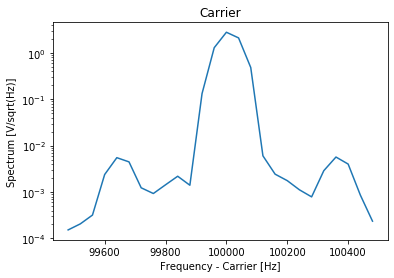

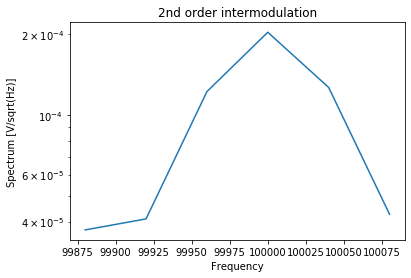

In [23]:
#plt.plot(freq[if0-300:if0+301]-f0, anps[if0-300:if0+301])
fmin=1.17e6-5e2
fmax=1.17e6+5e2
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1]-f0, anps[ifmin:ifmax+1])
plt.title("Carrier")
plt.yscale("log")
plt.xlabel("Frequency - Carrier [Hz]")
plt.ylabel("Spectrum [V/sqrt(Hz)]")

plt.figure()
fmin=1e5-1e2
fmax=1e5+1e2
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1], anps[ifmin:ifmax+1])
plt.title("2nd order intermodulation")
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Spectrum [V/sqrt(Hz)]")



Text(0, 0.5, 'Frequency spectrum (V/sqrt(Hz)')

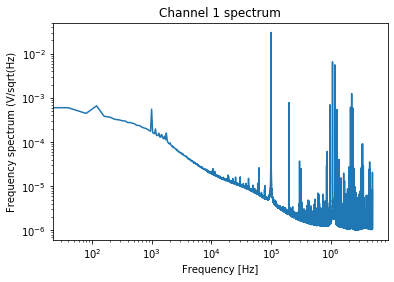

In [24]:
ch = 1

anps = np.zeros(N)
for event in parsed_data.values():
#    z = fft(event[ch]['data']*w)
    z = fft(event[ch]['data'])
    anps += np.abs(z)

#anps *= 2./N/len(parsed_data)/0.42/np.sqrt(df)          # 0.42 for Blackman window
anps *= 2./N/len(parsed_data)
plt.loglog(freq[0:N2], anps[0:N2])
plt.title('Channel {0:d} spectrum'.format(ch))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency spectrum (V/sqrt(Hz)")

Text(0, 0.5, 'Frequency spectrum (V/sqrt(Hz)')

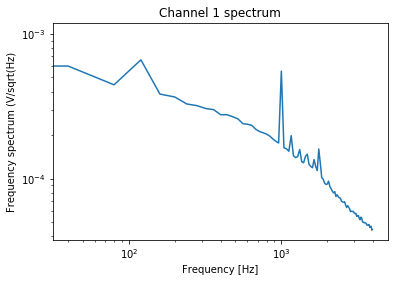

In [25]:
%matplotlib inline
plt.loglog(freq[0:100], anps[0:100])
plt.title('Channel {0:d} spectrum'.format(ch))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency spectrum (V/sqrt(Hz)")

Text(0, 0.5, 'Spectrum [V/sqrt(Hz)]')

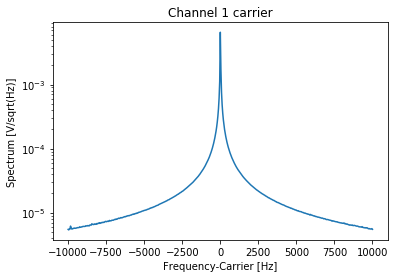

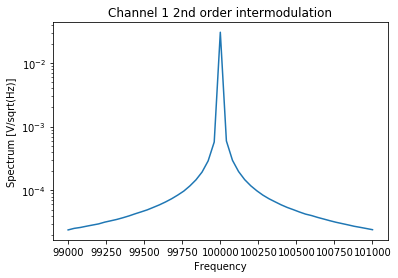

In [26]:
#plt.plot(freq[if0-300:if0+301]-f0, anps[if0-300:if0+301])
fmin=f0-1e4
fmax=f0+1e4
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1]-f0, anps[ifmin:ifmax+1])
plt.title("Channel {0:d} carrier".format(ch))
plt.yscale("log")
plt.xlabel("Frequency-Carrier [Hz]")
plt.ylabel("Spectrum [V/sqrt(Hz)]")

plt.figure()
fmin=1e5-1e3
fmax=1e5+1e3
ifmin=int(fmin/df)
ifmax=int(fmax/df)

plt.plot(freq[ifmin:ifmax+1], anps[ifmin:ifmax+1])
plt.title("Channel {0:d} 2nd order intermodulation".format(ch))
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Spectrum [V/sqrt(Hz)]")


In [27]:
from scipy.signal import butter, sosfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5*fs
    high = highcut / nyq
    sos = butter(order, high, btype='low', output='sos')
    return sos

def butter_filter(data, sos):
    y = sosfilt(sos, data)
    return y

# define the filter
f0=1e5
band_lowf = f0-1e4 # 2*f0-1e5
band_highf = f0+1e4 # 2*f0+1e5
low_highf = 1e4
order = 9

band_sos = butter_bandpass(band_lowf, band_highf, fs, order=order)
low_sos = butter_lowpass(low_highf, fs, order=order)
low_sos2 = butter_bandpass(2000, low_highf, fs, order=order)

#print(low_sos)


In [28]:
# DDC

# precompute cosine and sine weights
sinLO = np.sin(2*np.pi*t*f0)
cosLO = np.cos(2*np.pi*t*f0)


In [29]:
f0

100000.0

Text(0.5, 0, 'Frequency [Hz]')

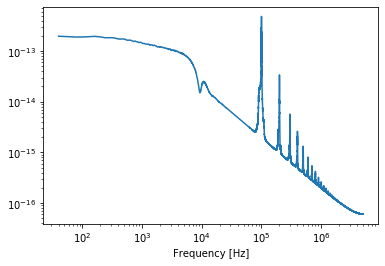

In [30]:
ch=1
anps = np.zeros(N)

for event in parsed_data.values():
    data = event[ch]['data']
#    lo   = event[0]['data']
    dataf = butter_filter(data, low_sos)
    
    # downmix
#ddc = butter_filter(df*lo,low_sos)
#    ddc = butter_filter(data*lo,low_sos2)

    ddcI = butter_filter(dataf*cosLO,low_sos)
    ddcQ = butter_filter(dataf*sinLO,low_sos)
    ddc = np.sqrt(ddcI*ddcI+ddcQ*ddcQ)
    
    z = fft(ddc)
    anps += np.abs(z)

anps *= 2./N/len(parsed_data)   #/np.sqrt(df)         
plt.loglog(freq[1:N2], anps[1:N2])
plt.xlabel("Frequency [Hz]")

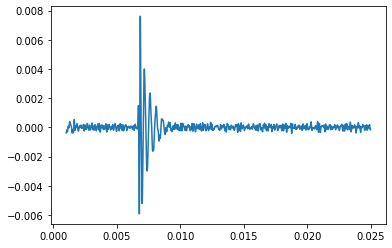

In [31]:
part = 0
ch = 1
data = parsed_data[part][ch]['data']
dataf = butter_filter(data, low_sos2)
    
# downmix
#ddc = butter_filter(df*lo,low_sos)
#    ddc = butter_filter(data*lo,low_sos2)

ddcI = butter_filter(dataf*cosLO,low_sos)
ddcQ = butter_filter(dataf*sinLO,low_sos)
ddc = np.sqrt(ddcI*ddcI+ddcQ*ddcQ)


toff=0.001
tl=0.2
off=int(toff*fs)
l=int(tl*fs)

#plt.scatter(ddcQ[off:],ddcI[off:])
#plt.figure()
plt.plot(t[off:off+l],dataf[off:off+l])

In [32]:
ch_info

{0: {'range': 30.0, 'inputZ': 1000000.0, 'attenuation': 1.0},
 1: {'range': 0.2, 'inputZ': 1000000.0, 'attenuation': 1.0}}

Mean filter: baselineRMS = 2.538656675371293e-15
Mean filter: amplitude = 1.7250408799020442e-12
Mean filter: res = 0.15%, 8.8 eV
RMS filter: baselineRMS = 2.5642979862688102e-14
RMS filter: amplitude = 2.228383715787073e-12
RMS filter: res = 1.15%, 69.0 eV


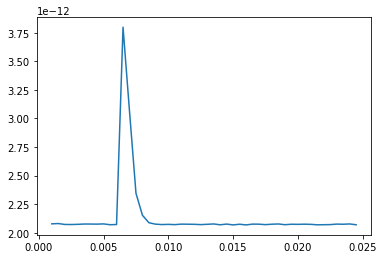

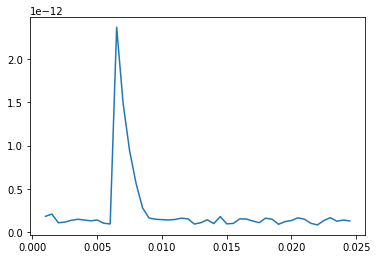

In [36]:
# decimating mean and RMS filter

decFact = 5000
ndec = int(len(ddc)/decFact)
tdec = np.arange(ndec)/fs*decFact
(wf_mean,wf_rms) = decFilter(ddc,decFact)
#(wf_mean,wf_rms) = decFilter(butter_filter(np.diff(dataf),low_sos2),decFact)



toff=0.001
tl=0.03
off=int(toff*fs/decFact)
l=int(tl*fs/decFact)

plt.plot(tdec[off:off+l],wf_mean[off:off+l])
plt.figure()
plt.plot(tdec[off:off+l],wf_rms[off:off+l])

# resolution with mean filter
toffbase = 0.01
tlbase=0.02
offbase=int(toffbase*fs/decFact)
lbase=int(tlbase*fs/decFact)
peak = peakDetect(wf_mean[off:off+l],threshold=3e-12)[0]
(baseAve,baseRMS) = baseline(wf_mean[offbase:offbase+lbase])

print('Mean filter: baselineRMS = {}'.format(baseRMS))
print('Mean filter: amplitude = {}'.format(peak-baseAve))
print('Mean filter: res = {0:.2f}%, {1:.1f} eV'.format(100*baseRMS/(peak-baseAve),6000*baseRMS/(peak-baseAve)))

peak = peakDetect(wf_rms[off:off+l],threshold=1e-12)[0]
(baseAve,baseRMS) = baseline(wf_rms[offbase:offbase+lbase])

print('RMS filter: baselineRMS = {}'.format(baseRMS))
print('RMS filter: amplitude = {}'.format(peak-baseAve))
print('RMS filter: res = {0:.2f}%, {1:.1f} eV'.format(100*baseRMS/(peak-baseAve),6000*baseRMS/(peak-baseAve)))



In [216]:
# store DDC output

# parameters
decFact = 2000
toff = 0.001     # skip the first msec to avoid glitch due the bandpass filter
off=int(toff*fs)

new_fs = fs/decFact
ndec = len(ddc[off:])//decFact

# copy headers
new_header = header_info.copy()
new_header['Sampling Frequency'] = '{}'.format(new_fs)
new_header['Acquired points'] = '{0:d}'.format(ndec)
new_header['# channels'] = 1      # will only store one waveform

new_ch_info = {}
new_ch_info[1] = ch_info[1].copy()
new_header

{'Iteration number': '0',
 'Iteration time': '60',
 'Sampling Frequency': '5000.0',
 'Acquired points': '120',
 'Trigger Position': '10',
 'Trigger channel': '0',
 '# channels': 1,
 'CH0 Vertical range': '30.000000',
 'CH0 Input impedance': '1000000',
 'CH0 Probe attenuation': '1',
 'CH1 Vertical range': '0.200000',
 'CH1 Input impedance': '1000000',
 'CH1 Probe attenuation': '1',
 'BK channel': '1',
 'BK waveform': '',
 'BK amplitude': '0.000000',
 'BK offset': '0.000000',
 'BK frequency': '0.000000',
 'BK phase': '0.000000',
 'Start time UNIX': 1632176812.495564,
 'Start date': '9/20/2021',
 'Start time': '3:26:52 PM',
 'Final iteration': '6',
 'Real time': '332.456269',
 'Live time': '1.999848',
 'Trigger number': '2712',
 'Stop time UNIX': 1632177146.1676488,
 'Stop date': '9/20/2021',
 'Stop Time': '3:32:26 PM'}

In [221]:
# new waveforms 

new_data = {}
ch = 1
i=0
#long_array = np.array(0)
ampArray = []
for event in parsed_data.values():
    data = event[ch]['data']
    header = event[ch]['header']
    header[3] = ndec
    
    dataf = butter_filter(data, low_sos2)
    
    # downmix
    ddcI = butter_filter(dataf*cosLO,low_sos)
    ddcQ = butter_filter(dataf*sinLO,low_sos)
    ddc = np.sqrt(ddcI*ddcI+ddcQ*ddcQ)
    (wf_mean,wf_rms) = decFilter(ddc[off:],decFact)

    new_data[i] = {ch: {'header': header, 'data': wf_mean}}
    i+=1
#    long_array = np.append(long_array,wf_mean)

    # look for pulses
    pulses = peakDetect(wf_mean,threshold=2.15e-12)
    ampArray.extend(pulses)
    
#print(new_data[0])


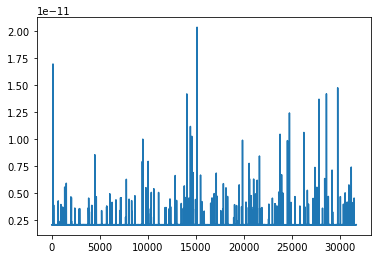

In [225]:
#%matplotlib widget
%matplotlib inline
#print(len(new_data[0][1]['data']),len(long_array))
plt.plot(np.arange(len(long_array)-1),long_array[1:])
#plt.hist(ampArray,bins=100,range=(2.5e-12,10e-12))
#plt.show()

In [133]:
#%pip install --user deepdish
import deepdish as dd

In [219]:
dd.io.save(dir+run+"filtered"+partial+".hdf5",{'header_info': new_header, 'ch_info': new_ch_info, 'data': new_data},compression='blosc')

In [289]:
test = dd.io.load(dir+run+"filtered"+partial+".hdf5")
test['data'][2]

{1: {'header': [1632177112.8564005, 3.3969670312217204e-06, 1, 120],
  'data': array([2.06579181e-12, 2.07283501e-12, 2.07143425e-12, 2.07134624e-12,
         2.07742405e-12, 2.07386548e-12, 2.07715825e-12, 2.08009861e-12,
         2.07081982e-12, 2.06796571e-12, 2.07671322e-12, 2.07285391e-12,
         2.08045554e-12, 2.06699864e-12, 2.07096671e-12, 2.06875212e-12,
         2.06793981e-12, 2.07411687e-12, 2.07090900e-12, 2.07228580e-12,
         2.06843954e-12, 2.07561079e-12, 2.07220143e-12, 2.06606179e-12,
         2.06981318e-12, 2.07960844e-12, 2.07033193e-12, 2.07316803e-12,
         2.06955522e-12, 2.06236894e-12, 2.07635693e-12, 2.06707998e-12,
         2.07189723e-12, 2.07155743e-12, 2.07473597e-12, 2.07437820e-12,
         2.06709486e-12, 2.08090989e-12, 2.07221183e-12, 2.06991779e-12,
         2.07305553e-12, 2.06918562e-12, 2.07184400e-12, 2.07454779e-12,
         2.07822486e-12, 2.06710823e-12, 2.06672569e-12, 2.07119390e-12,
         2.06859381e-12, 2.06942330e-12, 2.0667

In [293]:
(amp,base,baseRMS) = AmpAndBaseline(wf,threshold=2.15e-12,preVeto=2,postVeto=16)
amp,base,baseRMS

peakList = []
baseList = []
rmsList = []
for frame in test['data'].values():
    wf = frame[1]['data']
    (amp,base,baseRMS) = AmpAndBaseline(wf,threshold=2.15e-12,preVeto=2,postVeto=16)
    peakList.extend(amp)
    baseList.append(base)
    rmsList.append(baseRMS)
    

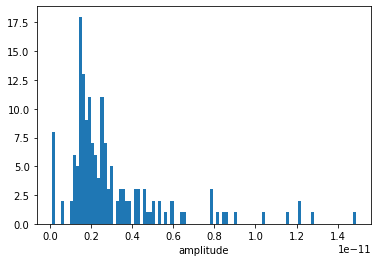

MPV = 1.490e-12


In [324]:
(n,b,p) = plt.hist(peakList,bins=100)
plt.xlabel('amplitude')
plt.show()
mpvAmp = 0.5*(b[np.argmax(n)]+b[np.argmax(n)+1])
print('MPV = {0:.3e}'.format(mpvAmp))

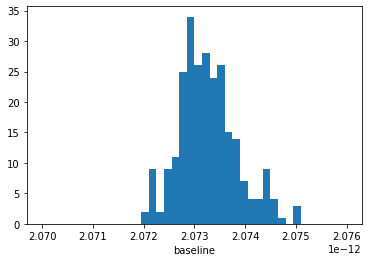

Average baseline = 2.073e-12


In [325]:
(n,b,p) = plt.hist(baseList,bins=40,range=(2.07e-12,2.076e-12))
plt.xlabel('baseline')
plt.show()
aveBase = np.median(baseList)
print('Median baseline = {0:.3e}'.format(aveBase))

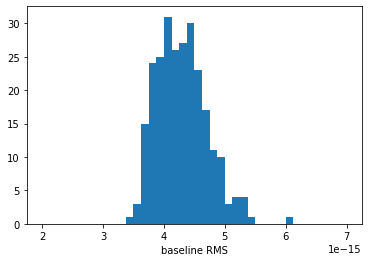

Average RMS = 4.287e-15
Resolution: 0.29%, 17.3 eV


In [326]:
(n,b,p) = plt.hist(rmsList,bins=40,range=(0.2e-14,0.7e-14))
plt.xlabel('baseline RMS')
plt.show()
aveRMS = np.median(rmsList)
print('Median RMS = {0:.3e}'.format(aveRMS))
print('Resolution: {0:.2f}%, {1:.1f} eV'.format(100*aveRMS/mpvAmp,6000*aveRMS/mpvAmp))

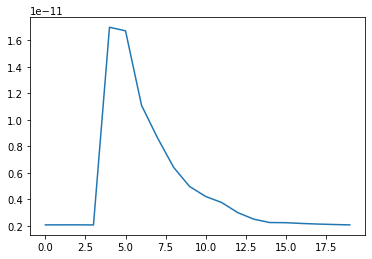

In [243]:
plt.plot(np.arange(len(wf))[0:20],wf[0:20])

In [282]:
peaks = find_peaks(wf,height=2.15e-12)
ipeak = peaks[0]
ipeak

array([ 4, 76])

In [274]:
preVeto=2
postVeto=16
baseIndices = ~np.in1d(np.arange(len(wf)),np.concatenate([np.arange(i-preVeto,i+postVeto) for i in ipeak]))
(baseAve,baseRMS) = baseline(wf[baseIndices])
(baseAve,baseRMS)

(2.0731182303814837e-12, 3.945148929597204e-15)